# Creating figures

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as sco
import numpy_linalg as la
import sl_py_tools.matplotlib_tricks as mplt
import sl_py_tools.numpy_tricks.markov as ma
import sl_py_tools.numpy_tricks.markov.params as mp
import complex_synapse as cs
import complex_synapse.optimise as cso
import complex_synapse.optimise.shorten as sh
from sl_py_tools.import_tricks import reload

In [2]:
np.set_printoptions(precision=3, suppress=False, linewidth=90)
mplt.rc_fonts()
mplt.rc_colours()

In [3]:
saved = np.load('optim.npz', allow_pickle=True)
s = saved['s']
envelope_theory = saved['envelope_theory']
envelope_gen = saved['envelope_gen']
envelope_srl = saved['envelope_srl']
senvelope_gen = saved['senvelope_gen']
models_gen = saved['models_gen']
models_srl = saved['models_srl']
smodels_gen = saved['smodels_gen']
options = saved['options'][()]
nst = saved['nst'][()]
saved.close()
t = 1 / s
jmp=0.7

In [9]:
reload(cs)
reload(mp)
reload(la)

Reloading complex_synapse.synapse_mem
Reloading sl_py_tools.arg_tricks
Reloading sl_py_tools.numpy_tricks
Reloading sl_py_tools.numpy_tricks.markov
Reloading sl_py_tools.numpy_tricks.markov._helpers
Reloading sl_py_tools.numpy_tricks.markov.markov
Reloading sl_py_tools.numpy_tricks.markov.params
Reloading sl_py_tools.numpy_tricks.markov._to_matrix
Reloading sl_py_tools.numpy_tricks.markov._to_params
Reloading sl_py_tools.numpy_tricks.markov._helpers
Reloading sl_py_tools.numpy_tricks.markov._to_matrix
Reloading sl_py_tools.numpy_tricks.markov._to_params
Reloading numpy_linalg._lnarray
Reloading numpy_linalg.gufuncs
Reloading numpy_linalg.gufuncs._families
Reloading numpy_linalg.gufuncs._gufuncs_cloop
Reloading numpy_linalg.gufuncs._gufuncs_blas
Reloading numpy_linalg.gufuncs._gufuncs_lu_solve
Reloading numpy_linalg.gufuncs._gufuncs_qr_lstsq
Reloading numpy_linalg.gufuncs._util
Reloading numpy_linalg.version
Reloading packaging.version
Reloading packaging._structures
Reloading packaging

## Examples

In [5]:
serial = cs.SynapseMemoryModel.build(cs.builders.build_serial, nst, jmp=jmp)
cascade = cs.SynapseMemoryModel.build(cs.builders.build_cascade, nst, jmp=jmp)

In [6]:
serial_snr = serial.snr_exp_ave(t)
cascade_snr = cascade.snr_exp_ave(t)

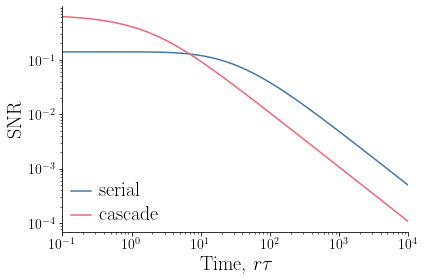

In [7]:
fig_sc, ax = plt.subplots()
ax.loglog(t, serial_snr, label='serial')
ax.loglog(t, cascade_snr, label='cascade')
ax.set_xlabel(r"Time, $r\tau$")
ax.set_ylabel("SNR")
ax.set_xlim(1e-1, 1e4)
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)

### Test shifting

In [4]:
model = cso.make_model(nst=nst, serial=True, frac=0.3).view(cs.SynapseMemoryModel)
laplace = model.snr_laplace(1 / t)
with model.shifted(1/t):
    shift_peq = model.snr_area()
with model.shifted(1/t, la.ones(nst) / nst):
    shift_ones = model.snr_area()
np.fabs(laplace - shift_peq).max()[()], np.fabs(laplace - shift_ones).max()[()]

(9.71445146547012e-17, 0.0011320263087917434)

# Envelopes

In [5]:
nst = 10
s = la.geomspace(1e-4, 10, 50)
options = {'repeats': 10, 'method': 'SLSQP'}
envelope_theory = cso.proven_envelope_laplace(s, nst)

## Theory

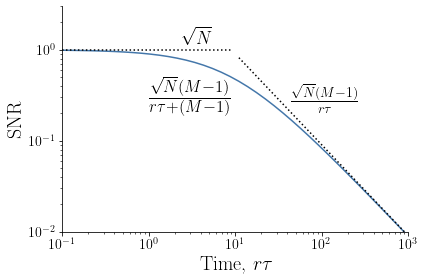

In [6]:
fig_th, ax = plt.subplots()
t_pts = np.array([1e-1, 0.9e1, 1.1e1, 1e4])
ax.loglog(1/s, envelope_theory * s, label='theory')
ax.loglog(t_pts[:2], np.ones(2), 'k:')
ax.loglog(t_pts[-2:], (nst-1) / t_pts[-2:], 'k:')
ax.set_xlabel(r"Time, $r\tau$")
ax.set_ylabel("SNR")
ax.set_xlim(1e-1, 1e3)
ax.set_ylim(1e-2, 3)
ind = 30
ax.text(t_pts[2]/2, 1.1, r"$\sqrt{N}$", 
        horizontalalignment='right', verticalalignment='bottom', fontsize=18)
ax.text(t_pts[-2]*4, (nst-1) / (t_pts[-2] * 4), r"$\frac{\sqrt{N}(M-1)}{r\tau}$", 
        horizontalalignment='left', verticalalignment='bottom', fontsize=20)
ax.text(1/s[ind], envelope_theory[ind] * s[ind], r"$\frac{\sqrt{N}(M-1)}{r\tau + (M-1)}$", 
        horizontalalignment='right', verticalalignment='top', fontsize=24)
mplt.clean_axes(ax)


## Optimisation

In [7]:
envelope_gen, models_gen = cso.optim_laplace_range(s, nst, serial=False, **options)
envelope_srl, models_srl = cso.optim_laplace_range(s, nst, serial=True, **options)



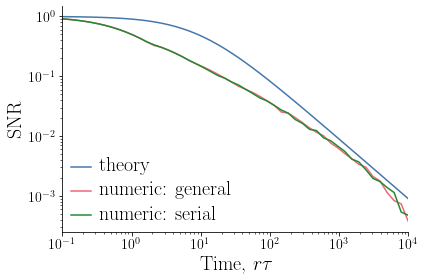

In [8]:
fig_num, ax = plt.subplots()
ax.loglog(1/s, envelope_theory * s, label='theory')
ax.loglog(1/s, envelope_gen * s, label='numeric: general')
ax.loglog(1/s, envelope_srl * s, label='numeric: serial')
ax.set_xlabel(r"Time, $r\tau$")
ax.set_ylabel("SNR")
ax.set_xlim(1/s[-1], 1/s[0])
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)

### Shifted optimisation

In [ ]:
senvelope_gen, smodels_gen = cso.optim_laplace_range(
    s, nst, maker=cso.shifted_problem, cond_thresh=1e3, cond_lim=True, **options)


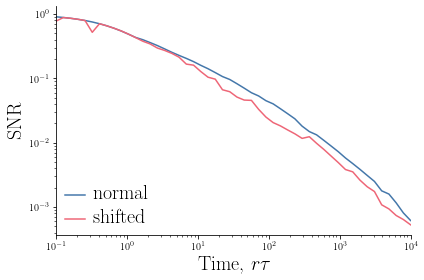

In [16]:
fig_shift, ax = plt.subplots()
ax.loglog(1/s, envelope_gen * s, label='normal')
ax.loglog(1/s, senvelope_gen * s, label='shifted')
ax.set_xlabel(r"Time, $r\tau$")
ax.set_ylabel("SNR")
ax.set_xlim(1/s[-1], 1/s[0])
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)

## Heuristic

In [4]:
s_two = sh.s_star(2)
s_sticky = sh.s_star(nst)
env_heuristic = cso.heuristic_envelope_laplace(s, nst)

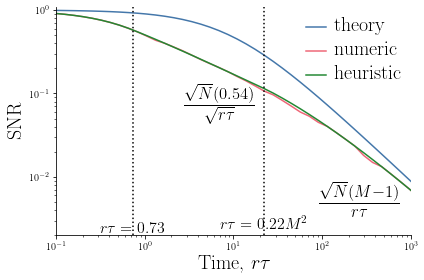

In [7]:
fig_heuristic, ax = plt.subplots()
ax.loglog(1/s, envelope_theory * s, label='theory')
ax.loglog(1/s, envelope_gen * s, label='numeric')
ax.loglog(1/s, env_heuristic * s, label='heuristic')
ax.set_ylim(2e-3, 1.1)
ax.set_xlim(1/s[-1], 1e3)
ax.axvline(x=1/s_two, color='k', linestyle=':')
ax.axvline(x=1/s_sticky, color='k', linestyle=':')
ax.set_xlabel(r"Time, $r\tau$")
ax.set_ylabel("SNR")
ind = 27
ax.text(1/s[ind], env_heuristic[ind] * s[ind], r"$\frac{\sqrt{N}(0.54)}{\sqrt{r\tau}}$", 
        horizontalalignment='right', verticalalignment='top', fontsize=24)
ind = 11
ax.text(1/s[ind], env_heuristic[ind] * s[ind], r"$\frac{\sqrt{N}(M-1)}{r\tau}$", 
        horizontalalignment='right', verticalalignment='top', fontsize=24)
ax.text(1/s_two, ylim[0], r"$r\tau = 0.73$", 
        horizontalalignment='center', verticalalignment='bottom', fontsize=16)
ax.text(1/s_sticky, ylim[0] * 1.1, r"$r\tau = 0.22M^2$", 
        horizontalalignment='center', verticalalignment='bottom', fontsize=16)
lg = ax.legend(loc="upper right")
mplt.clean_axes(ax)

## Saving/loading

In [39]:
np.savez_compressed("optim", s=s, envelope_theory=envelope_theory,
envelope_gen=envelope_gen, envelope_srl=envelope_srl, senvelope_gen=senvelope_gen, 
models_gen=models_gen, models_srl=models_srl, smodels_gen=smodels_gen,
nst=nst, options=options)

In [36]:
fig_sc.savefig("../../Notes/Figures/serial_vs_cascade.pdf")
fig_th.savefig("../../Notes/Figures/LenvProven.pdf")
fig_num.savefig("../../Notes/Figures/LenvNum.pdf")
fig_shift.savefig("../../Notes/Figures/LenvShift.pdf")
fig_cond.savefig("../../Notes/Figures/shift_cond.pdf")
fig_heuristic.savefig("../../Notes/Figures/LenvHeuristic.pdf")

## Diagnosis and treatment

In [35]:
bad_inds, = (senvelope_gen / envelope_gen < 0.6).nonzero()
bad_inds

array([ 3, 16, 17, 18, 19, 20], dtype=int64)

In [34]:
reoptions = options.copy()
reoptions['repeats'] = 20
senvelope_gen, smodels_gen = cso.reoptim_laplace_range(
    bad_inds, s, senvelope_gen, smodels_gen,
    maker=cso.shifted_problem, cond_thresh=1e3, cond_lim=False, **reoptions
)



In [8]:
conds = cso.check_cond_range(s, smodels_gen)


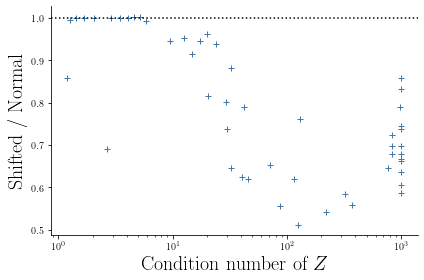

In [9]:
fig_cond, ax = plt.subplots()
# good = senvelope_gen < envelope_gen
# bad = np.logical_not(good)
# ax.semilogx(conds[good], senvelope_gen[good] / envelope_gen[good], '+',
#             conds[bad], senvelope_gen[bad] / envelope_gen[bad], '+')
ax.semilogx(conds, senvelope_gen / envelope_gen, '+')
ax.axhline(y=1, color='k', linestyle=':')
ax.set_xlabel('Condition number of $Z$')
ax.set_ylabel('Shifted / Normal')
# mplt.centre_spines(ax, 1, 1, arrow=False, centre_tick='x')
mplt.clean_axes(ax)